Download data

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-11-09 19:29:57--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.49.84, 13.226.49.80, 13.226.49.83, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.49.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  16.0MB/s    in 0.2s    

2020-11-09 19:29:57 (16.0 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [ ]:
%matplotlib inline


Generating Names with a Character-Level RNN
*******************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In the :doc:`last tutorial </intermediate/char_rnn_classification_tutorial>`
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import math
import random

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Irish', 'Czech', 'Portuguese', 'German', 'Vietnamese', 'Polish', 'Chinese', 'French', 'Russian', 'Dutch', 'Spanish', 'Greek', 'English', 'Italian', 'Japanese', 'Arabic', 'Korean', 'Scottish']
O'Neal


Creating the Network
====================

This network extends `the last tutorial's RNN <#Creating-the-Network>`__
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

class RNN_no_pre_char(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_no_pre_char, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined_i2o = torch.cat((category, input, hidden), 1)
        input_combined_i2h = torch.cat((category, torch.zeros_like(input), hidden), 1)
        hidden = self.i2h(input_combined_i2h)
        output = self.i2o(input_combined_i2o)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [ ]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [ ]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [ ]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [ ]:
criterion = nn.NLLLoss()

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

def train_2(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn2.initHidden()

    rnn2.zero_grad()

    loss = 0

    # change only first iteration
    output, hidden = rnn2(category_tensor, input_line_tensor[0], hidden)
    l = criterion(output, target_line_tensor[0])
    loss += l
    
    # clear category tensor after the first iteration
    category_tensor = torch.zeros_like(category_tensor)

    for i in range(1, input_line_tensor.size(0)):
        output, hidden = rnn2(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer_2.step()

    return output, loss.item() / input_line_tensor.size(0)

def train_3(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn3.zero_grad()

    loss = 0

    # the same as train
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn3(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer_3.step()

    return output, loss.item() / input_line_tensor.size(0)

def train_4(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn4.initHidden()

    rnn4.zero_grad()

    loss = 0

    # the same as train_2
    # change only first iteration
    output, hidden = rnn4(category_tensor, input_line_tensor[0], hidden)
    l = criterion(output, target_line_tensor[0])
    loss += l
    
    # clear category tensor after the first iteration
    category_tensor = torch.zeros_like(category_tensor)

    for i in range(1, input_line_tensor.size(0)):
        output, hidden = rnn4(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer_4.step()

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [ ]:
rnn = RNN(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses = []
all_validation_losses = []
train_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    train_loss += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

    if iter % plot_every == 0:
        all_train_losses.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss = eval_dataset(validation_data)

        # save model with best validation loss
        if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
            torch.save(rnn, 'char_rnn_generation_model.pt')
        all_validation_losses.append(average_validation_loss)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 32s) 	2.3661
5000 	12% 	(1m 11s) 	2.3542
7500 	18% 	(1m 49s) 	2.3185
10000 	25% 	(2m 28s) 	2.2804
12500 	31% 	(3m 6s) 	2.2540
15000 	37% 	(3m 45s) 	2.2451
17500 	43% 	(4m 23s) 	2.2494
20000 	50% 	(5m 2s) 	2.2338
22500 	56% 	(5m 40s) 	2.2097
25000 	62% 	(6m 18s) 	2.2039
27500 	68% 	(6m 57s) 	2.2099
30000 	75% 	(7m 35s) 	2.2690
32500 	81% 	(8m 14s) 	2.1925
35000 	87% 	(8m 52s) 	2.1955
37500 	93% 	(9m 32s) 	2.1869
40000 	100% 	(10m 16s) 	2.2175


In [ ]:
rnn2 = RNN(n_letters, 128, n_letters)
optimizer_2 = torch.optim.Adam(rnn2.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses_2 = []
all_validation_losses_2 = []
train_loss_2 = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate_2(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn2.initHidden()
    loss = 0

    output, hidden = rnn2(category_tensor, input_line_tensor[0], hidden)
    l = criterion(output, target_line_tensor[0])
    loss += l
    
    category_tensor = torch.zeros_like(category_tensor)
    
    for i in range(1, input_line_tensor.size()[0]):
        output, hidden = rnn2(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset_2(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate_2(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train_2(*randomTrainingExample())
    train_loss_2 += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_2 / plot_every))

    if iter % plot_every == 0:
        all_train_losses_2.append(train_loss_2 / plot_every)
        train_loss_2 = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss = eval_dataset_2(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_2) == 0 or average_validation_loss < min(all_validation_losses_2):
            torch.save(rnn2, 'char_rnn_generation_model_2.pt')
        all_validation_losses_2.append(average_validation_loss)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 33s) 	2.4566
5000 	12% 	(1m 13s) 	2.3651
7500 	18% 	(1m 53s) 	2.3381
10000 	25% 	(2m 32s) 	2.2800
12500 	31% 	(3m 11s) 	2.2630
15000 	37% 	(3m 50s) 	2.2946
17500 	43% 	(4m 29s) 	2.2190
20000 	50% 	(5m 8s) 	2.2144
22500 	56% 	(5m 47s) 	2.2775
25000 	62% 	(6m 27s) 	2.2010
27500 	68% 	(7m 7s) 	2.2297
30000 	75% 	(7m 47s) 	2.2363
32500 	81% 	(8m 27s) 	2.2088
35000 	87% 	(9m 7s) 	2.2153
37500 	93% 	(9m 46s) 	2.1778
40000 	100% 	(10m 25s) 	2.2678


In [ ]:
rnn3 = RNN_no_pre_char(n_letters, 128, n_letters)
optimizer_3 = torch.optim.Adam(rnn3.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses_3 = []
all_validation_losses_3 = []
train_loss_3 = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate_3(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn3.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn3(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset_3(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate_3(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train_3(*randomTrainingExample())
    train_loss_3 += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_3 / plot_every))

    if iter % plot_every == 0:
        all_train_losses_3.append(train_loss_3 / plot_every)
        train_loss_3 = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss = eval_dataset_3(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_3) == 0 or average_validation_loss < min(all_validation_losses_3):
            torch.save(rnn3, 'char_rnn_generation_model_3.pt')
        all_validation_losses_3.append(average_validation_loss)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 35s) 	2.4478
5000 	12% 	(1m 17s) 	2.4003
7500 	18% 	(1m 59s) 	2.4145
10000 	25% 	(2m 42s) 	2.3466
12500 	31% 	(3m 23s) 	2.3111
15000 	37% 	(4m 5s) 	2.3266
17500 	43% 	(4m 48s) 	2.3834
20000 	50% 	(5m 29s) 	2.3008
22500 	56% 	(6m 11s) 	2.3115
25000 	62% 	(6m 53s) 	2.3193
27500 	68% 	(7m 35s) 	2.2818
30000 	75% 	(8m 16s) 	2.3070
32500 	81% 	(8m 58s) 	2.3038
35000 	87% 	(9m 40s) 	2.3051
37500 	93% 	(10m 21s) 	2.2775
40000 	100% 	(11m 3s) 	2.2600


In [ ]:
rnn4 = RNN_no_pre_char(n_letters, 128, n_letters)
optimizer_4 = torch.optim.Adam(rnn4.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses_4 = []
all_validation_losses_4 = []
train_loss_4 = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate_4(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn4.initHidden()
    loss = 0

    output, hidden = rnn4(category_tensor, input_line_tensor[0], hidden)
    l = criterion(output, target_line_tensor[0])
    loss += l
    
    category_tensor = torch.zeros_like(category_tensor)
    
    for i in range(1, input_line_tensor.size()[0]):
        output, hidden = rnn4(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset_4(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate_4(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train_4(*randomTrainingExample())
    train_loss_4 += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss_4 / plot_every))

    if iter % plot_every == 0:
        all_train_losses_4.append(train_loss_4 / plot_every)
        train_loss_4 = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss = eval_dataset_4(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_4) == 0 or average_validation_loss < min(all_validation_losses_4):
            torch.save(rnn4, 'char_rnn_generation_model_4.pt')
        all_validation_losses_4.append(average_validation_loss)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 35s) 	2.5088
5000 	12% 	(1m 17s) 	2.4807
7500 	18% 	(2m 0s) 	2.4381
10000 	25% 	(2m 42s) 	2.3946
12500 	31% 	(3m 25s) 	2.3461
15000 	37% 	(4m 8s) 	2.3376
17500 	43% 	(4m 50s) 	2.3191
20000 	50% 	(5m 32s) 	2.3427
22500 	56% 	(6m 14s) 	2.3329
25000 	62% 	(6m 56s) 	2.2964
27500 	68% 	(7m 37s) 	2.3346
30000 	75% 	(8m 20s) 	2.3561
32500 	81% 	(9m 1s) 	2.3117
35000 	87% 	(9m 44s) 	2.3157
37500 	93% 	(10m 26s) 	2.2822
40000 	100% 	(11m 8s) 	2.3225


Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




Average test loss of rnn1: 2.422970293908395
Average test loss of rnn2: 2.4501380685930743
Average test loss of rnn3: 2.4603155239398817
Average test loss of rnn4: 2.453283947195242


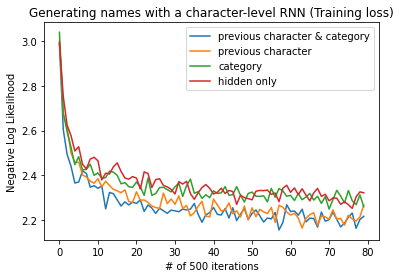

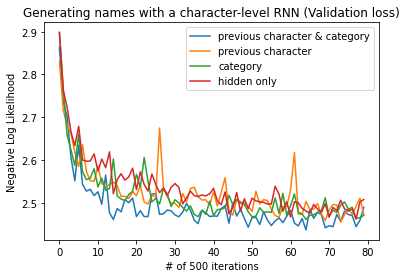

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses)
plt.plot(all_train_losses_2)
plt.plot(all_train_losses_3)
plt.plot(all_train_losses_4)
plt.title('Generating names with a character-level RNN (Training loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(['previous character & category', 'previous character', 'category', 'hidden only'], loc='upper right')

plt.figure()
plt.plot(all_validation_losses)
plt.plot(all_validation_losses_2)
plt.plot(all_validation_losses_3)
plt.plot(all_validation_losses_4)
plt.title('Generating names with a character-level RNN (Validation loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(['previous character & category','previous character', 'category', 'hidden only'], loc='upper right')

# evaluate on test set and print average test loss
rnn = torch.load('char_rnn_generation_model.pt')
average_test_loss = eval_dataset(test_data)
rnn2 = torch.load('char_rnn_generation_model_2.pt')
average_test_loss_2 = eval_dataset_2(test_data)
rnn3 = torch.load('char_rnn_generation_model_3.pt')
average_test_loss_3 = eval_dataset_3(test_data)
rnn4 = torch.load('char_rnn_generation_model_4.pt')
average_test_loss_4 = eval_dataset_4(test_data)
print('Average test loss of rnn1: ' + str(average_test_loss))
print('Average test loss of rnn2: ' + str(average_test_loss_2))
print('Average test loss of rnn3: ' + str(average_test_loss_3))
print('Average test loss of rnn4: ' + str(average_test_loss_4))

Based on the graph and data above,  models with category have a better performance than those without category, but overall that is a small improvement. 

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Robellovi
Urbong
Shinov
Gonder
Ester
Rouder
Salaza
Para
Allara
Chonn
Hon
Ina


Exercises
=========

-  Try with a different dataset of category -> line, for example:

   -  Fictional series -> Character name
   -  Part of speech -> Word
   -  Country -> City

-  Use a "start of sentence" token so that sampling can be done without
   choosing a start letter
-  Get better results with a bigger and/or better shaped network

   -  Try the nn.LSTM and nn.GRU layers
   -  Combine multiple of these RNNs as a higher level network


